In [52]:
import pandas as pd
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot


In [20]:
# resumé de l'étape précédente : cleaning
data = pd.read_csv('./Data/SMSSpamCollection.txt', sep='\t', header=None)
data.columns = ['label', 'content']

en_stop_words = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()


def clean_data(texte):
    texte_punct = "".join([ch for ch in texte if ch not in string.punctuation])
    tokens = re.split("\W+", texte_punct)
    texte_clean = [ps.stem(word)
                   for word in tokens if word not in en_stop_words]
    return texte_clean


data.head()


,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Vectorisation

In [2]:
# representation sous forme de chiffre
vectorization_full = CountVectorizer(analyzer=clean_data)
vect_final = vectorization_full.fit_transform(data['content'])
print(vect_final.shape)
# 5572 = mails, 8193 = colones = mots dans tous les mails

(5572, 8193)


In [3]:
# matrice difficile à lire
print(vectorization_full.get_feature_names_out())

['', '0', '008704050406', '0089mi', '0121', '01223585236', '01223585334', '0125698789', '02', '020603', '0207', '02070836089', '02072069400', '02073162414', '02085076972', '020903', '021', '050703', '0578', '06', '060505', '061104', '07008009200', '07046744435', '07090201529', '07090298926', '07099833605', '071104', '07123456789', '0721072', '07732584351', '07734396839', '07742676969', '07753741225', '0776xxxxxxx', '07786200117', '077xxx', '078', '07801543489', '07808', '07808247860', '07808726822', '07815296484', '07821230901', '0784987', '0789xxxxxxx', '0794674629107880867867', '0796xxxxxx', '07973788240', '07xxxxxxxxx', '0800', '08000407165', '08000776320', '08000839402', '08000930705', '08000938767', '08001950382', '08002888812', '08002986030', '08002986906', '08002988890', '08006344447', '0808', '08081263000', '08081560665', '0825', '0844', '08448350055', '08448714184', '0845', '08450542832', '08452810071', '08452810073', '08452810075over18', '0870', '08700621170150p', '0870121318

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [4]:
# application du travail sur un petit bout du dataframe pour pouvoir visualiser 
data0 = data[:5]
vect_final0 = vectorization_full.fit_transform(data0['content'])
print(vect_final0.shape, vectorization_full.get_feature_names_out())

(5, 58) ['08452810075over18', '2', '2005', '21st', '87121', 'alreadi', 'amor', 'appli', 'around', 'avail', 'buffet', 'bugi', 'c', 'cine', 'comp', 'crazi', 'cup', 'dont', 'dun', 'e', 'earli', 'entri', 'fa', 'final', 'free', 'go', 'goe', 'got', 'great', 'hor', 'i', 'joke', 'jurong', 'la', 'lar', 'live', 'may', 'n', 'nah', 'ok', 'oni', 'point', 'questionstd', 'ratetc', 'receiv', 'say', 'text', 'think', 'though', 'tkt', 'txt', 'u', 'usf', 'wat', 'wif', 'win', 'wkli', 'world']


In [5]:
# matrice difficile à lire
vect_final0

<5x58 sparse matrix of type '<class 'numpy.int64'>'
	with 59 stored elements in Compressed Sparse Row format>

In [18]:
# transformer la matrice en dataframe, ce li de cette façon : lignes = mails, Cologne = mots, croisement = existence du mot dans le mail
pd_vect_final0 = pd.DataFrame(vect_final0.toarray())
pd_vect_final0.columns = vectorization_full.get_feature_names_out()
pd_vect_final0

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,08452810075over18,2,2005,21st,87121,alreadi,amor,appli,around,avail,...,though,tkt,txt,u,usf,wat,wif,win,wkli,world
0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,1,1,1,1,1,0,0,1,0,0,...,0,1,1,0,0,0,0,1,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0


### vectorisation_contextuelle_N_grams

In [11]:
# cas spéciale pour l'inpute : one string lematized
def clean_data2(texte):
    texte_punct = "".join([ch for ch in texte if ch not in string.punctuation])
    tokens = re.split("\W+", texte_punct)
    texte_clean = " ".join([ps.stem(word) for word in tokens if word not in en_stop_words])
    return texte_clean

data['content_stemed'] = data['content'].apply(lambda x: clean_data2(x))
data

,label,content,content_stemed
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think goe usf live around though
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,thi 2nd time tri 2 contact u u 750 pound prize...
5568,ham,Will ü b going to esplanade fr home?,will ü b go esplanad fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",piti mood soani suggest
5570,ham,The guy did some bitching but I acted like i'd...,the guy bitch i act like id interest buy somet...


In [13]:
#(2,2) on prend en considération 2 à 2 mots. (1,3) on prend en considération mot par mot après 2 par 2 après 3 par 3 par 3
vectorization_full_n_grams = CountVectorizer(ngram_range=(2,2))
vect_final_n_grams = vectorization_full_n_grams.fit_transform(data['content_stemed'])
print(vect_final_n_grams.shape)
# 5572 = mails, 34162 = colones = combinaison de mots dans tous les mails

(5572, 34162)


In [16]:
# application du travail sur un petit bout du dataframe pour pouvoir visualiser 
data0 = data[:5]
vect_final_n_grams = vectorization_full_n_grams.fit_transform(data0['content_stemed'])
print(vect_final_n_grams.shape, vectorization_full_n_grams.get_feature_names_out())

# transformer la matrice en dataframe, ce li de cette façon : lignes = mails, Cologne = mots, croisement = existence du mot dans le mail
pd_vect_final_n_grams = pd.DataFrame(vect_final_n_grams.toarray())
pd_vect_final_n_grams.columns = vectorization_full_n_grams.get_feature_names_out()
pd_vect_final_n_grams.head()


(5, 50) ['2005 text', '21st may', '87121 receiv', 'alreadi say', 'amor wat', 'appli 08452810075over18', 'around though', 'avail bugi', 'buffet cine', 'bugi great', 'cine got', 'comp win', 'crazi avail', 'cup final', 'dont think', 'dun say', 'earli hor', 'entri questionstd', 'entri wkli', 'fa 87121', 'fa cup', 'final tkt', 'free entri', 'go jurong', 'goe usf', 'got amor', 'great world', 'hor alreadi', 'joke wif', 'jurong point', 'la buffet', 'lar joke', 'live around', 'may 2005', 'nah dont', 'ok lar', 'point crazi', 'questionstd txt', 'ratetc appli', 'receiv entri', 'say earli', 'text fa', 'think goe', 'tkt 21st', 'txt ratetc', 'usf live', 'wif oni', 'win fa', 'wkli comp', 'world la']


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,2005 text,21st may,87121 receiv,alreadi say,amor wat,appli 08452810075over18,around though,avail bugi,buffet cine,bugi great,...,say earli,text fa,think goe,tkt 21st,txt ratetc,usf live,wif oni,win fa,wkli comp,world la
0,0,0,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,1,1,0,0,1,0,0,0,0,...,0,1,0,1,1,0,0,1,1,0
3,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,0,0,0


### vectorisation_tf-idf
TF-IDF associe des valeurs réels qui represente des poids associé aux mots par rappport aux documents, plus ce poids est élevé plus cela veut dire qu'un document beaucoups plus d'occurence de ce mot par rapport aux autres documents   
$$
{TF-IDF} : {W_{ij}} = tf_{i,j} * \log{(\frac{N}{df_i})}
$$


$$ {tf_{ij}: taux d'apparition du terme i dans document j}  $$ 
$$ {N : nombre de documents total}   $$
$$ {df_i : nombre de document contenant le terme i} $$


In [23]:
vectorization_full_tf = TfidfVectorizer(analyzer=clean_data)
vect_final_tf = vectorization_full_tf.fit_transform(data['content'])
print(vect_final_tf.shape)


(5572, 8193)


In [25]:
# application du travail sur un petit bout du dataframe pour pouvoir visualiser 
data0 = data[:5]
vect_final_tf = vectorization_full_tf.fit_transform(data0['content'])
print(vect_final_tf.shape, vectorization_full_tf.get_feature_names_out_out())


(5, 58) ['08452810075over18' '2' '2005' '21st' '87121' 'alreadi' 'amor' 'appli'
 'around' 'avail' 'buffet' 'bugi' 'c' 'cine' 'comp' 'crazi' 'cup' 'dont'
 'dun' 'e' 'earli' 'entri' 'fa' 'final' 'free' 'go' 'goe' 'got' 'great'
 'hor' 'i' 'joke' 'jurong' 'la' 'lar' 'live' 'may' 'n' 'nah' 'ok' 'oni'
 'point' 'questionstd' 'ratetc' 'receiv' 'say' 'text' 'think' 'though'
 'tkt' 'txt' 'u' 'usf' 'wat' 'wif' 'win' 'wkli' 'world']


In [26]:
pd_vect_final_tf = pd.DataFrame(vect_final_tf.toarray())
pd_vect_final_tf.columns = vectorization_full_tf.get_feature_names_out()
pd_vect_final_tf

,08452810075over18,2,2005,21st,87121,alreadi,amor,appli,around,avail,...,though,tkt,txt,u,usf,wat,wif,win,wkli,world
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.25,0.00000,0.000000,0.25,...,0.000000,0.00000,0.00000,0.000000,0.000000,0.25,0.000000,0.00000,0.00000,0.25
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00,0.00000,0.000000,0.00,...,0.000000,0.00000,0.00000,0.339393,0.000000,0.00,0.420669,0.00000,0.00000,0.00
2,0.19245,0.19245,0.19245,0.19245,0.19245,0.000000,0.00,0.19245,0.000000,0.00,...,0.000000,0.19245,0.19245,0.000000,0.000000,0.00,0.000000,0.19245,0.19245,0.00
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.293564,0.00,0.00000,0.000000,0.00,...,0.000000,0.00000,0.00000,0.473691,0.000000,0.00,0.000000,0.00000,0.00000,0.00
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00,0.00000,0.333333,0.00,...,0.333333,0.00000,0.00000,0.000000,0.333333,0.00,0.000000,0.00000,0.00000,0.00


## Feature Engineering
- Objectif : enrichir les données avec des informations utiles     
- Méthodes : Ajouter de nouvelles variables ou transformer les variables excitantes
- Exemples ajout : ajouter une variable pour : taux de caractères de ponctuations, taille des msg, taux de lettres en majuscules, variable binaire sur le mot "lol"
- Exemple transformation : application de la fonction puissance POW sur les variables existantes, normalisation des variables ou changement d'échelle

In [36]:
# utiliser les données de base avant les prétraitements
# calcule du nombres de caractère par mail
data['content_len'] = data['content'].apply(lambda x: len(x) - x.count(" "))
data

,label,content,content_len
0,ham,"Go until jurong point, crazy.. Available only ...",92
1,ham,Ok lar... Joking wif u oni...,24
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128
3,ham,U dun say so early hor... U c already then say...,39
4,ham,"Nah I don't think he goes to usf, he lives aro...",49
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,131
5568,ham,Will ü b going to esplanade fr home?,29
5569,ham,"Pity, * was in mood for that. So...any other s...",48
5570,ham,The guy did some bitching but I acted like i'd...,100


In [49]:
# calcule du taux de ponctuation dans un mail par rapport au nombre total de caractères
def count_punct(texte):
    binary_punct = [1 for ch in texte if ch in string.punctuation]
    nb_punct = sum(binary_punct)
    totale = len(texte) - texte.count(" ")
    return round(nb_punct/totale,4)*100 

data['punct_rate'] = data['content'].apply(lambda x: count_punct(x))
data

,label,content,content_len,punct_rate
0,ham,"Go until jurong point, crazy.. Available only ...",92,9.78
1,ham,Ok lar... Joking wif u oni...,24,25.00
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.69
3,ham,U dun say so early hor... U c already then say...,39,15.38
4,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.08
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,131,6.11
5568,ham,Will ü b going to esplanade fr home?,29,3.45
5569,ham,"Pity, * was in mood for that. So...any other s...",48,14.58
5570,ham,The guy did some bitching but I acted like i'd...,100,1.00


### visualisation du Feature Engineering
pour bien analyser nos deux variables qu'on a créées

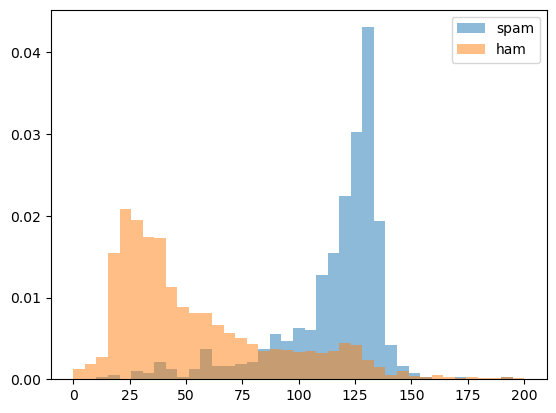

In [56]:
bins = np.linspace(0, 200, 40)
# np.linspace permet d’obtenir un tableau 1D allant d’une valeur de départ à une valeur de fin avec un nombre donné d’éléments.

pyplot.hist(data[data['label'] == 'spam']['content_len'], bins, alpha = 0.5, density=True, label='spam')
pyplot.hist(data[data['label'] == 'ham']['content_len'], bins, alpha = 0.5, density=True, label='ham')
pyplot.legend(loc='upper right')
pyplot.show()

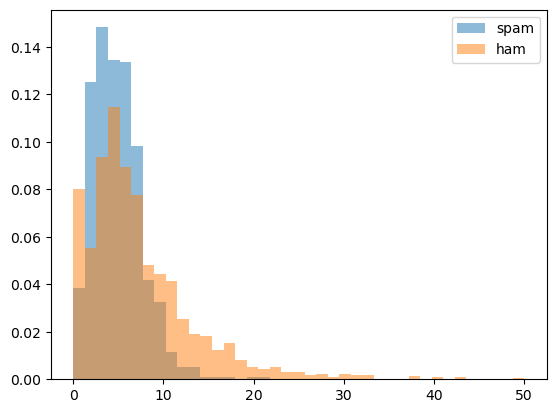

In [71]:
bins = np.linspace(0, 50, 40)
# np.linspace permet d’obtenir un tableau 1D allant d’une valeur de départ à une valeur de fin avec un nombre donné d’éléments.

# alpha = transperncy
pyplot.hist(data[data['label'] == 'spam']['punct_rate'],
            bins, alpha=0.5, density=True, label='spam')
pyplot.hist(data[data['label'] == 'ham']['punct_rate'],
            bins, alpha=0.5, density=True, label='ham')
pyplot.legend(loc='upper right')
pyplot.show()

conclusion : la variable content_len est intéréssante pour déscriminer les mails spams/hams, punct_rate non